<h3>Spark SQL</h3>

<p>Analize 
dataset using Spark SQL (working on one machine
multiple threads without full Hadoopoenvironment) and visualization tools. Present at least 5 different data exercises (at least 3 of them should
have some visualization)

<h4>Variant 3:  dataset -  NCHS - Death rates and life expectancy at birth</h4>

In [16]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import numpy as np

In [17]:
spark = SparkSession.builder.appName("dataset_analysis").getOrCreate()

<h5>Загрузка датасета</h5>


In [18]:
df = spark.read.csv("NCHS_-_Death_rates_and_life_expectancy_at_birth.csv", header=True, inferSchema=True)

In [19]:
df.show()

+----+---------+----------+-------------------------------+-----------------------+
|Year|     Race|       Sex|Average Life Expectancy (Years)|Age-adjusted Death Rate|
+----+---------+----------+-------------------------------+-----------------------+
|1900|All Races|Both Sexes|                           47.3|                 2518.0|
|1901|All Races|Both Sexes|                           49.1|                 2473.1|
|1902|All Races|Both Sexes|                           51.5|                 2301.3|
|1903|All Races|Both Sexes|                           50.5|                 2379.0|
|1904|All Races|Both Sexes|                           47.6|                 2502.5|
|1905|All Races|Both Sexes|                           48.7|                 2423.7|
|1906|All Races|Both Sexes|                           48.7|                 2399.0|
|1907|All Races|Both Sexes|                           47.6|                 2494.4|
|1908|All Races|Both Sexes|                           51.1|                 

<h5>Информация о структуре данных и общая статистика</h5>

In [31]:
df.printSchema()
df.describe().show()
total_rows = df.count()
print("Общее количество строк в датасете:", total_rows)

root
 |-- Year: integer (nullable = true)
 |-- Race: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Average Life Expectancy (Years): double (nullable = true)
 |-- Age-adjusted Death Rate: double (nullable = true)

+-------+------------------+---------+----------+-------------------------------+-----------------------+
|summary|              Year|     Race|       Sex|Average Life Expectancy (Years)|Age-adjusted Death Rate|
+-------+------------------+---------+----------+-------------------------------+-----------------------+
|  count|              1071|     1071|      1071|                           1065|                   1071|
|   mean|            1959.0|     NULL|      NULL|              64.50018779342723|       1593.06162464986|
| stddev|34.367176254942976|     NULL|      NULL|             11.843765212160816|      682.3693790261243|
|    min|              1900|All Races|Both Sexes|                           29.1|                  611.3|
|    max|              201

<h5>Cредняя продолжительность жизни при рождении и средняя смертность по годам</h5>

In [21]:
df.createOrReplaceTempView("data")
result = spark.sql("""SELECT 
                        Year, 
                        AVG(`Average Life Expectancy (Years)`) as AvgLifeExpectancy,
                        AVG(`Age-adjusted Death Rate`) as AvgDeathRate 
                        FROM data
                        GROUP BY Year
                        ORDER BY Year""")
result.show(119)

+----+------------------+------------------+
|Year| AvgLifeExpectancy|      AvgDeathRate|
+----+------------------+------------------+
|1900|42.644444444444446| 2819.488888888889|
|1901|44.099999999999994| 2758.633333333333|
|1902| 46.05555555555555|2596.2666666666664|
|1903| 44.87777777777777| 2706.633333333333|
|1904| 42.17777777777778|2862.2888888888892|
|1905|43.055555555555564|2759.6666666666665|
|1906|43.666666666666664|2666.8777777777777|
|1907|              42.8|2752.8999999999996|
|1908| 45.86666666666667|2542.0666666666666|
|1909|              46.8| 2495.811111111111|
|1910|45.333333333333336|2532.2222222222226|
|1911| 47.36666666666667|2487.3888888888887|
|1912| 48.52222222222221| 2452.588888888889|
|1913|48.077777777777776| 2429.266666666666|
|1914| 49.43333333333333| 2392.611111111111|
|1915| 49.60000000000001| 2445.777777777778|
|1916| 48.61111111111111|2476.9888888888886|
|1917| 47.38888888888889|2521.9222222222224|
|1918|36.833333333333336|2811.8777777777777|
|1919|    

<h5>Визуализация связи смертности среди разных полов и рас</h5>

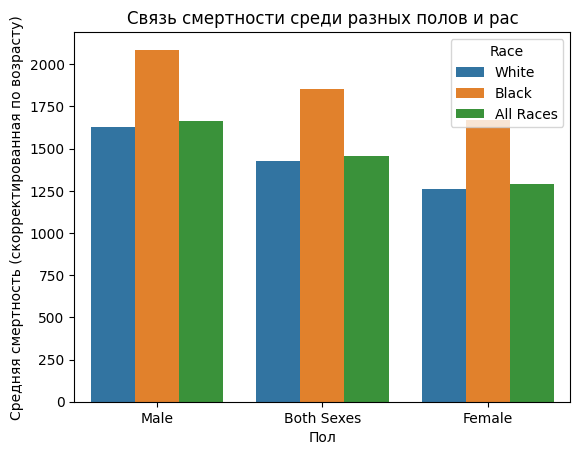

In [22]:
death_rate_by_sex_and_race = df.groupBy("Sex", "Race").avg("Age-adjusted Death Rate").toPandas()

sns.barplot(x="Sex", y="avg(Age-adjusted Death Rate)", hue="Race", data=death_rate_by_sex_and_race)
plt.xlabel("Пол")
plt.ylabel("Средняя смертность (скорректированная по возрасту)")
plt.title("Связь смертности среди разных полов и рас")
plt.show()

<h5>График изменения средней продолжительности жизни по годам</h5>

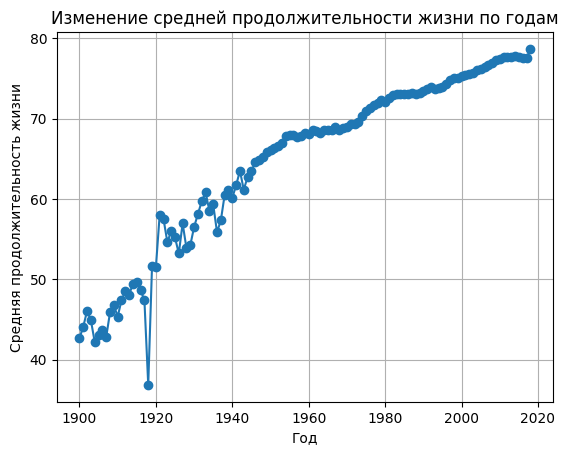

In [23]:
result = spark.sql("""
    SELECT 
        Year, 
        AVG(`Average Life Expectancy (Years)`) as AvgLifeExpectancy
    FROM data 
    GROUP BY Year
    ORDER BY Year
""")
years = result.select("Year").rdd.flatMap(lambda x: x).collect()
life_expectancy = result.select("AvgLifeExpectancy").rdd.flatMap(lambda x: x).collect()

plt.plot(years, life_expectancy, marker='o')
plt.xlabel("Год")
plt.ylabel("Средняя продолжительность жизни")
plt.title("Изменение средней продолжительности жизни по годам")
plt.grid(True)
plt.show()

<h5>График изменения средней смертности по годам</h5>

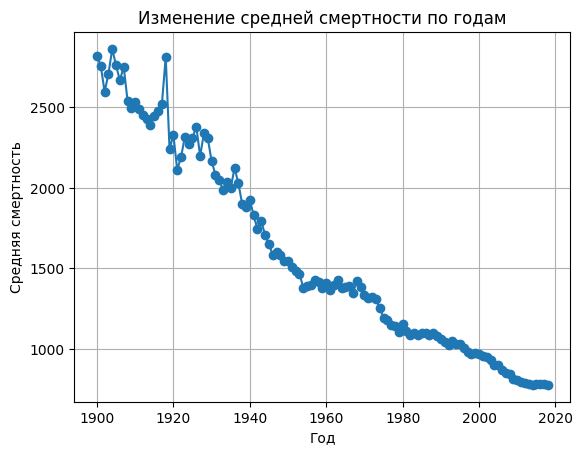

In [24]:
result = spark.sql("""
    SELECT 
        Year, 
        AVG(`Age-adjusted Death Rate`) as AvgDeathExpectancy
    FROM data 
    GROUP BY Year
    ORDER BY Year
""")
years = result.select("Year").rdd.flatMap(lambda x: x).collect()
death_expectancy = result.select("AvgDeathExpectancy").rdd.flatMap(lambda x: x).collect()

plt.plot(years, death_expectancy, marker='o')
plt.xlabel("Год")
plt.ylabel("Средняя смертность")
plt.title("Изменение средней смертности по годам")
plt.grid(True)
plt.show()

<h5>Смертность в сравнении с ожидаемой продолжительностью жизни</h5>

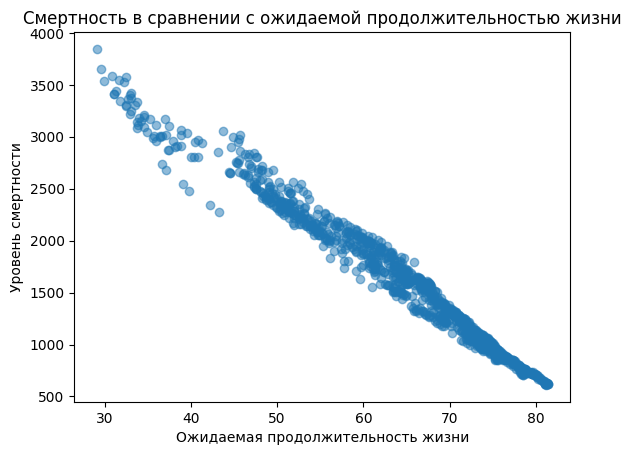

In [25]:
result = spark.sql("""
    SELECT 
        `Average Life Expectancy (Years)` as LifeExpectancy,
        `Age-adjusted Death Rate` as DeathRate
    FROM data
    WHERE `Average Life Expectancy (Years)` IS NOT NULL
    AND `Age-adjusted Death Rate` IS NOT NULL
""")

# Извлечение данных для графика
life_expectancy = [row["LifeExpectancy"] for row in result.collect()]
death_rate = [row["DeathRate"] for row in result.collect()]

plt.scatter(life_expectancy, death_rate, alpha=0.5)
plt.xlabel("Ожидаемая продолжительность жизни")
plt.ylabel("Уровень смертности")
plt.title("Смертность в сравнении с ожидаемой продолжительностью жизни")
plt.show()

<h5>Выделение Выбросов</h5>

In [29]:
result = spark.sql("""
    SELECT 
        `Average Life Expectancy (Years)` as LifeExpectancy,
        `Age-adjusted Death Rate` as DeathRate
    FROM data
    WHERE `Average Life Expectancy (Years)` IS NOT NULL
    AND `Age-adjusted Death Rate` IS NOT NULL
""")

life_expectancy = [row["LifeExpectancy"] for row in result.collect()]
death_rate = [row["DeathRate"] for row in result.collect()]

def identify_outliers(values, lower_bound, upper_bound):
    outliers = []
    for value in values:
        if value < lower_bound or value > upper_bound:
            outliers.append(value)
    return outliers

# Выделение выбросов для продолжительности жизни
life_expectancy_outliers = identify_outliers(life_expectancy, lower_bound_life, upper_bound_life)

# Выделение выбросов для уровня смертности
death_rate_outliers = identify_outliers(death_rate, lower_bound_death, upper_bound_death)
print("Выбросы ожидаемой продолжительности жизни:", life_expectancy_outliers)
print("Выбросы уровня смертности:", death_rate_outliers)

Выбросы ожидаемой продолжительности жизни: [30.8, 31.3, 31.1, 31.7, 29.1, 29.6, 31.8, 31.1, 29.9]
Выбросы уровня смертности: [3845.7, 3654.7]
